In [1]:
import scipy.io as sio
import scipy.io
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import butter, filtfilt
from scipy.signal import resample_poly               

In [2]:
# Load extracted PWD envelopes
mat = sio.loadmat('/home/tsu25/envelops/10_envelope.mat')
x_up = mat['x_up'].squeeze()
x_down = mat['x_down'].squeeze()

# Load processed fetal and maternal ECGs
mat_file_path = '/labs/katebilab/NinFEA_Data/Processed_Data/results01_10.mat'
mat_data = scipy.io.loadmat(mat_file_path)
fetal_ecg = mat_data['fref1'].flatten()
maternal_ecg = mat_data['mref'].flatten()
print("Length of fetal ECG: {}".format(len(fetal_ecg)))
print("Length of maternal ECG: {}".format(len(maternal_ecg)))

Length of fetal ECG: 76267
Length of maternal ECG: 76267


In [3]:
fetal_ecg = mat_data['fref1'].flatten()
maternal_ecg = mat_data['mref'].flatten()
print("Length of fetal ECG: {}".format(len(fetal_ecg)))
print("Length of maternal ECG: {}".format(len(maternal_ecg)))

Length of fetal ECG: 76267
Length of maternal ECG: 76267


In [4]:
print("Length of upper envelop: {}".format(len(x_up)))
print("Length of lower envelop: {}".format(len(x_down)))

Length of upper envelop: 10575
Length of lower envelop: 10575


In [5]:
assert(len(fetal_ecg)//2048 == len(x_up)//284)

### ECG / Dopper plotting

In [5]:
# down-sample ECG to 284 Hz
def downsample_ecg(ecg_origin, fs_orig=2048, fs_target=284):
    """
    Return ECG resampled from 2048 Hz to 284 Hz using polyphase FIR.
    """
    up, down = fs_target, fs_orig      
    return resample_poly(ecg_origin, up, down) 

# Plot simultaneous PWD upper envelope and fetal ECG
def plot_ecg_doppler_match_rate(fetal_ecg, doppler_env,
                                fs_ecg_orig=2048, fs_common=284,
                                start_time=0.0, duration=None,
                                ecg_units="mV", dop_units="arb."):
    """
    Down-sample ECG to fs_common (284 Hz by default) and plot alongside Doppler envelope.
    """
    # resample and build time axes
    ecg_ds = downsample_ecg(fetal_ecg, fs_orig=fs_ecg_orig, fs_target=fs_common)
    n_ecg_samples = len(ecg_ds)
    t = np.arange(n_ecg_samples) / fs_common

    # optional windowing
    s_idx = int(start_time * fs_common)
    if duration is not None:
        e_idx = s_idx + int(duration * fs_common)
        if e_idx > min(n_ecg_samples, len(doppler_env)):
            e_idx = min(n_ecg_samples, len(doppler_env))
    else:
        e_idx = min(n_ecg_samples, len(doppler_env))
    t      = t[s_idx:e_idx]
    ecg_ds = ecg_ds[s_idx:e_idx]
    doppler_seg = doppler_env[s_idx:e_idx] 

    # plot with twin-y axes
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax1.plot(t, ecg_ds, lw=1, label="Fetal ECG", color="C0")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"ECG ({ecg_units})", color="C0")
    ax1.tick_params(axis="y", labelcolor="C0")

    ax2 = ax1.twinx()
    ax2.plot(t, doppler_seg, lw=1, label="Doppler envelope", color="C1", alpha=0.7)
    ax2.set_ylabel(f"Doppler ({dop_units})", color="C1")
    ax2.tick_params(axis="y", labelcolor="C1")

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.set_title("Fetal ECG down-sampled to 284 Hz vs. Doppler upper envelope")
    fig.tight_layout()
    plt.show()

In [6]:
def plot_multiple_records(record_ids,
                          envelope_dir="/home/tsu25/envelops",
                          ecg_dir="/labs/katebilab/NinFEA_Data/Processed_Data",
                          fs_ecg=2048, fs_common=284,
                          window_start=0.0, window_len=None):
    """
    Plot Doppler & ECG for each record index in *record_ids* (0–60).

    Parameters
    ----------
    record_ids     : list[int]  – indices to plot, e.g. [0, 2, 5]
    envelope_dir   : str        – folder with '<idx>_envelope.mat'
    ecg_dir        : str        – folder with 'results01_<idx>.mat'
    window_start   : float      – seconds offset to begin plotting
    window_len     : float|None – seconds of data to display (None = full overlap)
    """
    for idx in record_ids:
        env_path = os.path.join(envelope_dir, f"{idx}_envelope.mat")
        ecg_path = os.path.join(ecg_dir,     f"results01_{idx}.mat")

        if not (os.path.exists(env_path) and os.path.exists(ecg_path)):
            print(f"[{idx}] missing file(s); skipping.")
            continue

        # load envelope
        env_mat = sio.loadmat(env_path)              
        x_up = env_mat["x_up"].squeeze()

        # load ECG traces
        ecg_mat = sio.loadmat(ecg_path)
        fetal_ecg = ecg_mat["fref1"].flatten()            
        
        print(f"[{idx}] plotting {len(fetal_ecg)/fs_ecg:.1f}s of data …")
        plot_ecg_doppler_match_rate(
            fetal_ecg, x_up, fs_common=fs_common,
            start_time=window_start, duration=window_len
        )

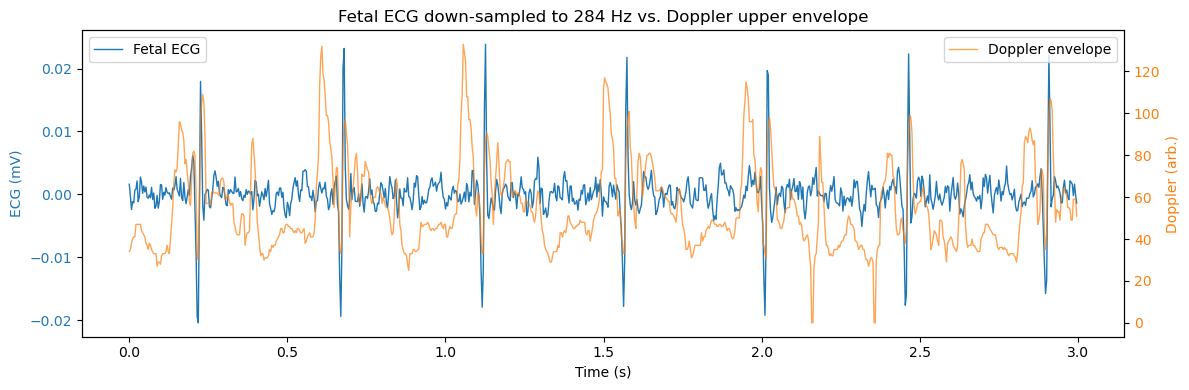

In [7]:
plot_ecg_doppler_match_rate(fetal_ecg, x_up, start_time=0, duration=3)

[1] plotting 28.1s of data …


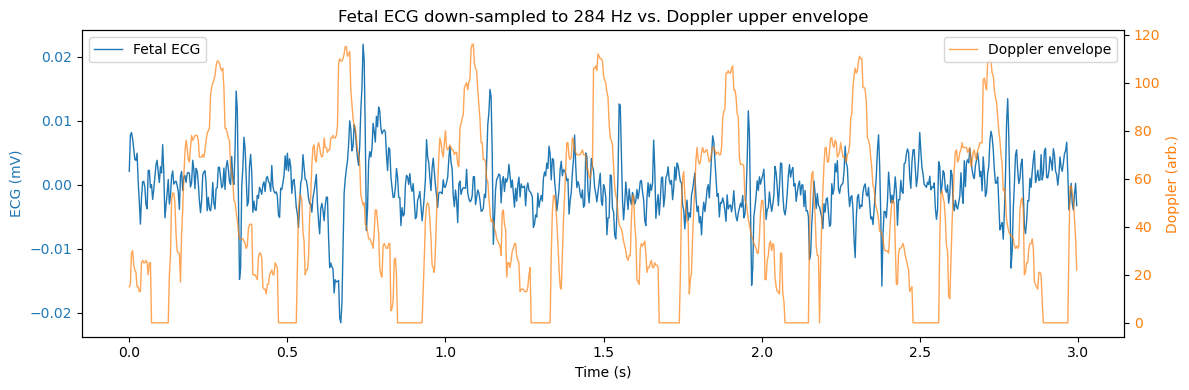

[2] plotting 28.6s of data …


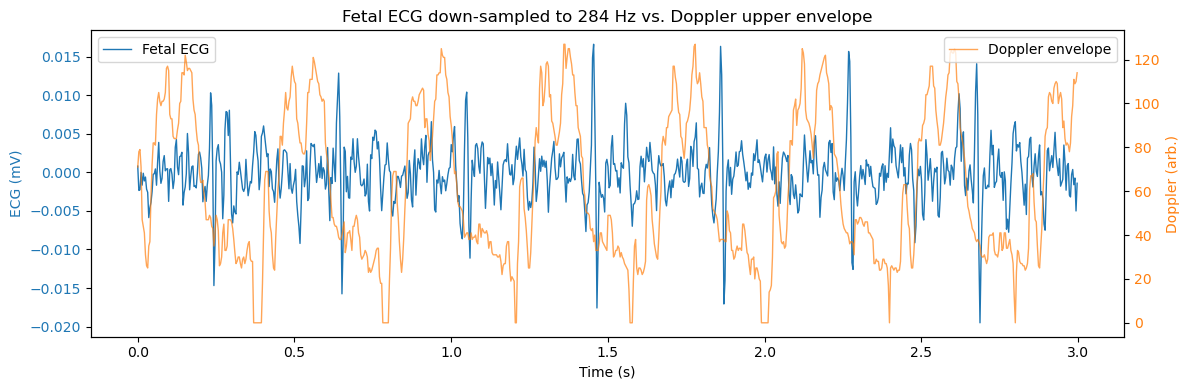

[3] plotting 53.1s of data …


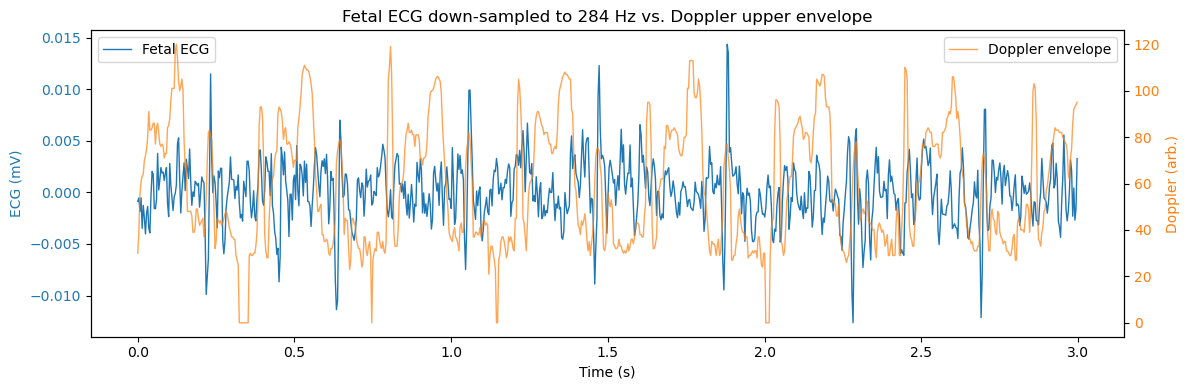

[4] plotting 44.3s of data …


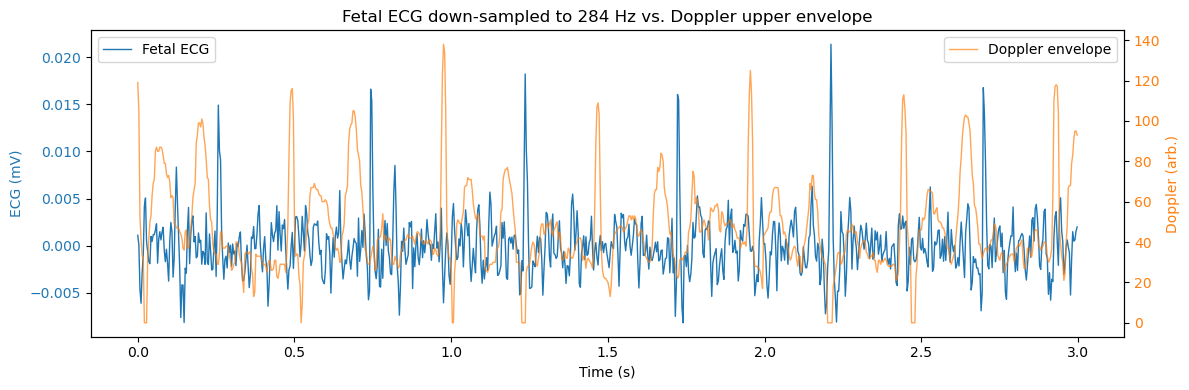

[5] plotting 47.3s of data …


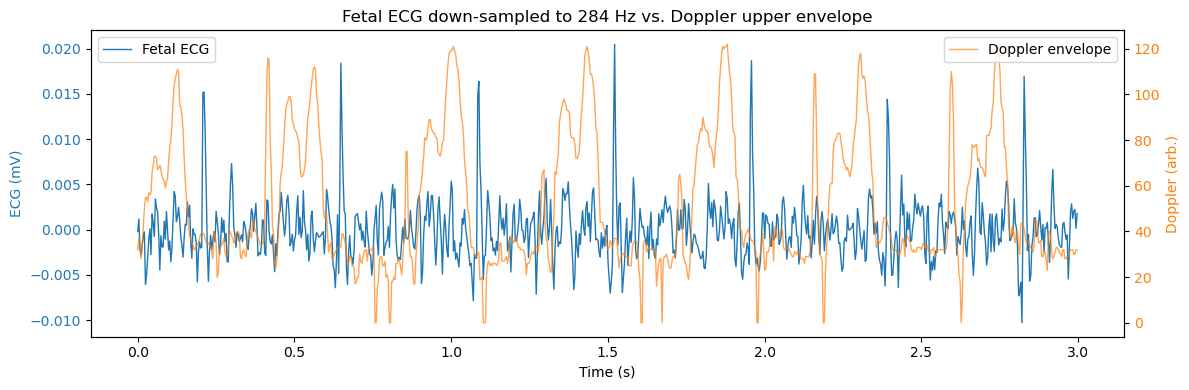

[6] plotting 43.4s of data …


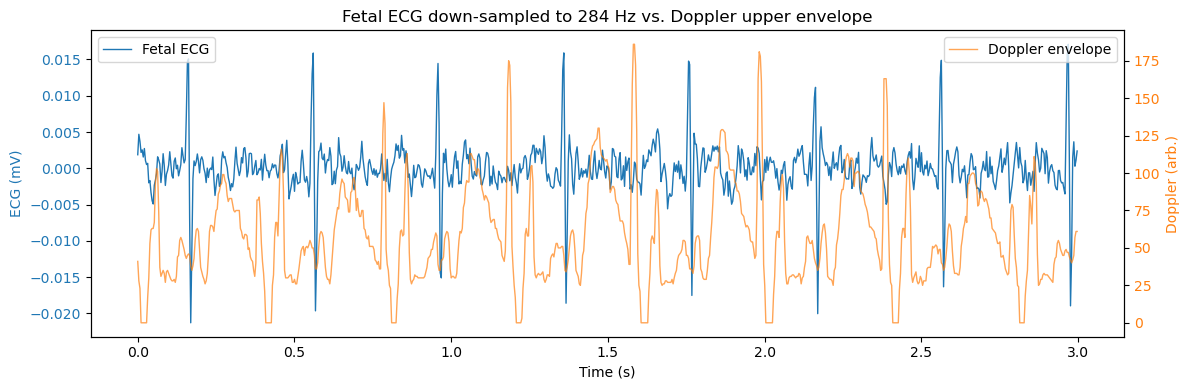

[7] plotting 52.6s of data …


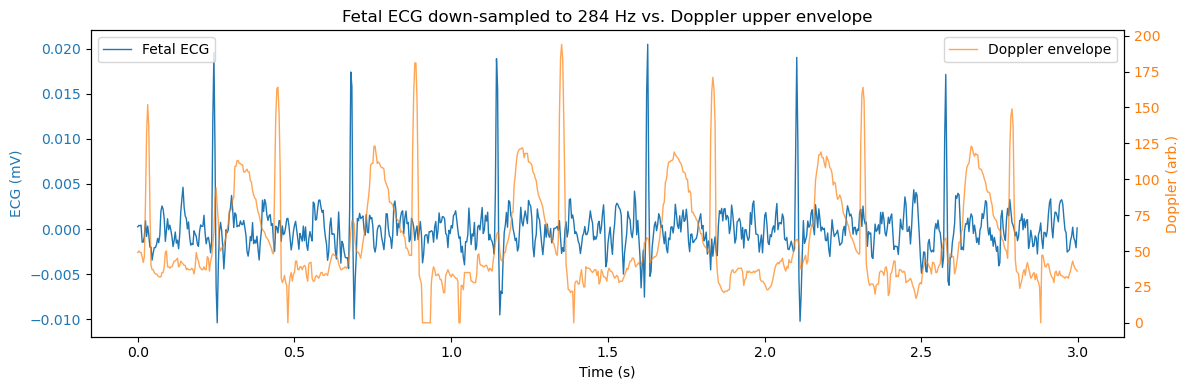

[8] plotting 13.0s of data …


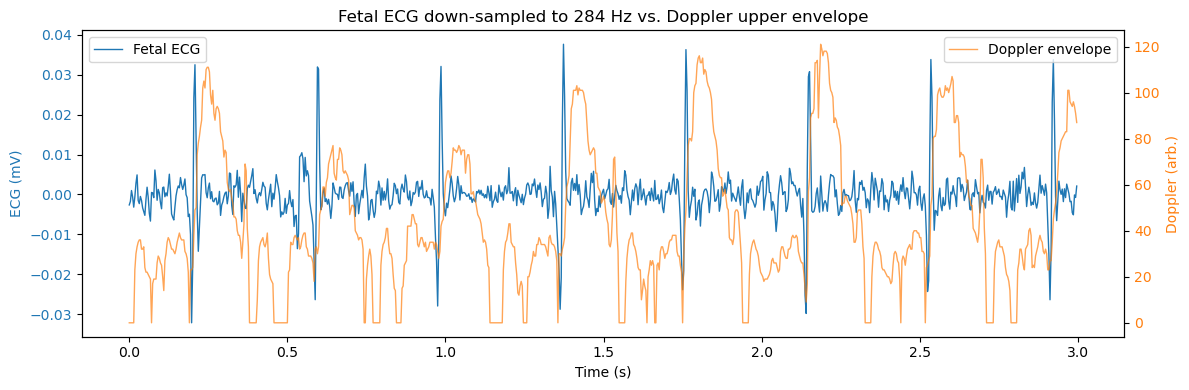

[9] plotting 12.6s of data …


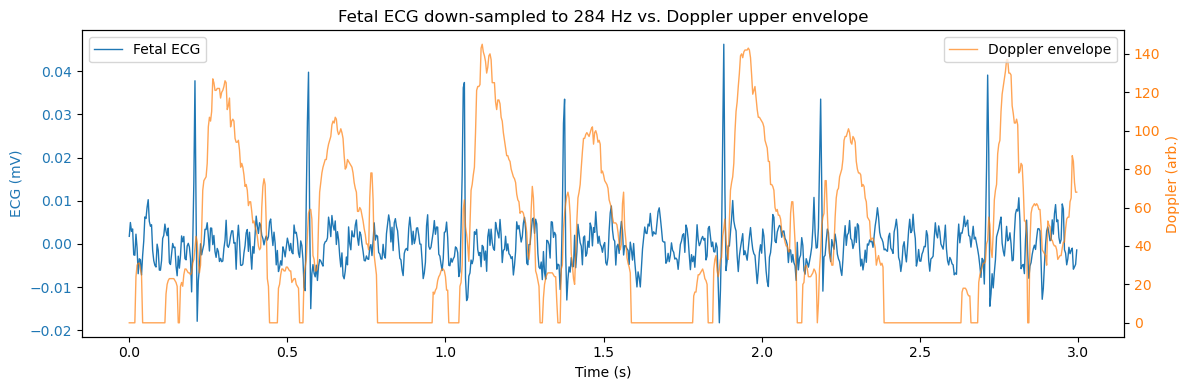

[10] plotting 37.2s of data …


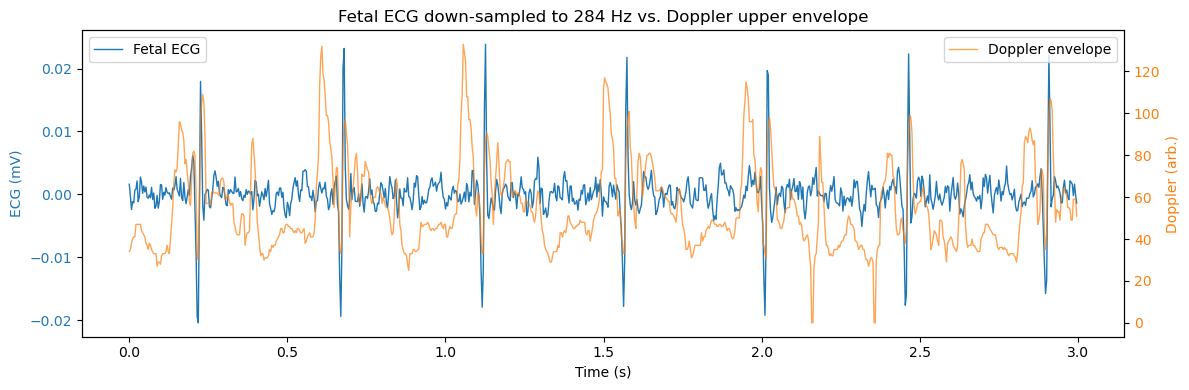

In [8]:
plot_multiple_records([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], window_len = 3)

In [ ]:
mat = sio.loadmat('/home/tsu25/envelops/1_envelope.mat')
x_up = mat['x_up'].squeeze()[:1000]
x_down = mat['x_down'].squeeze()[:1000]

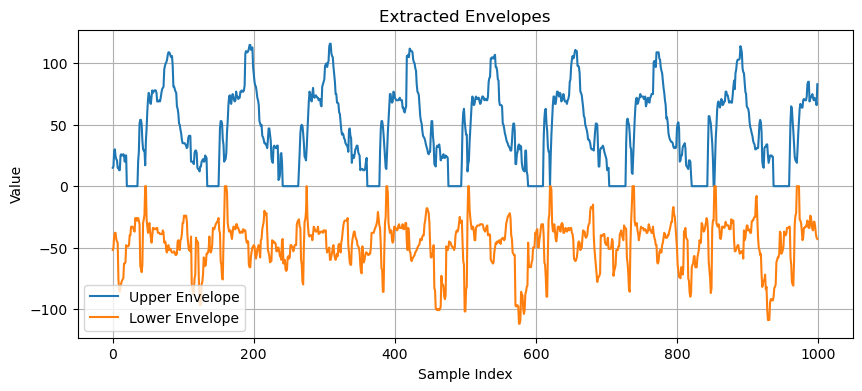

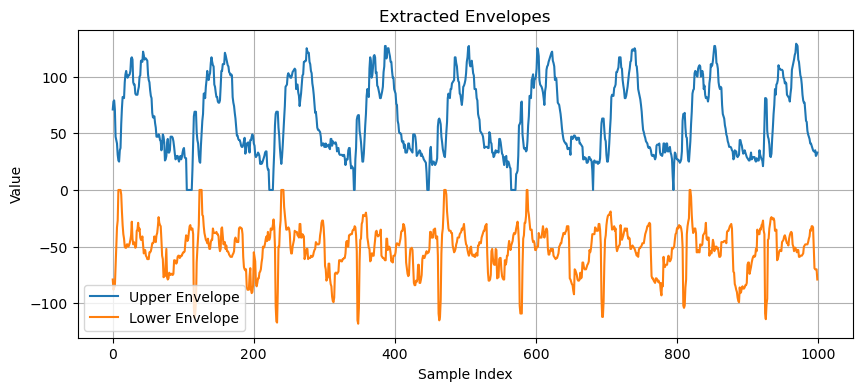

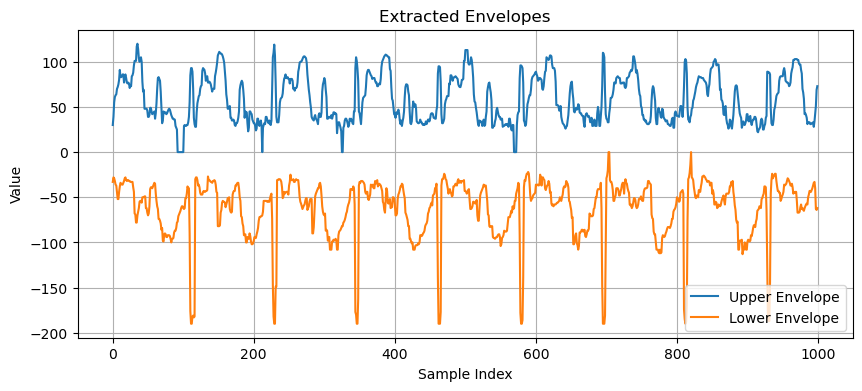

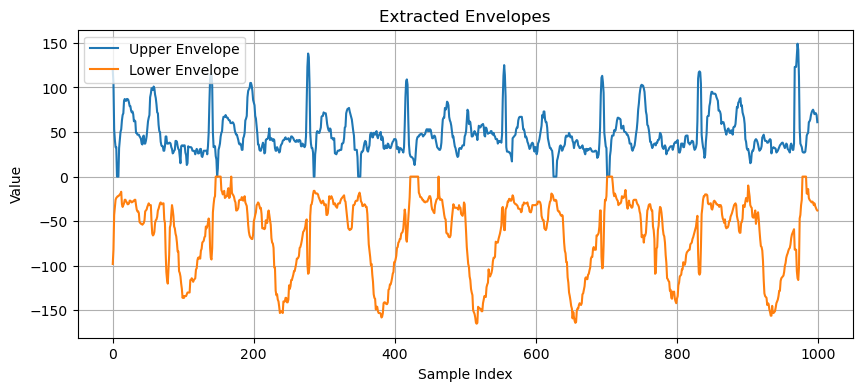

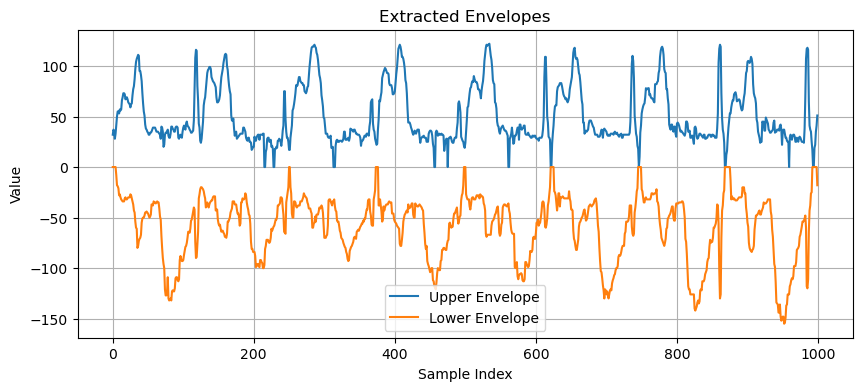

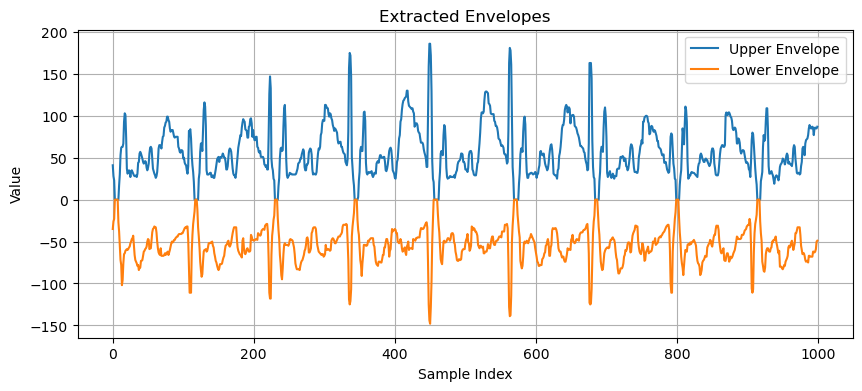

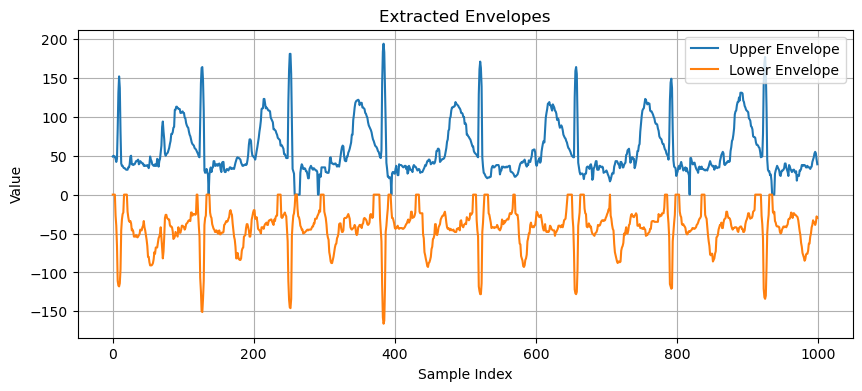

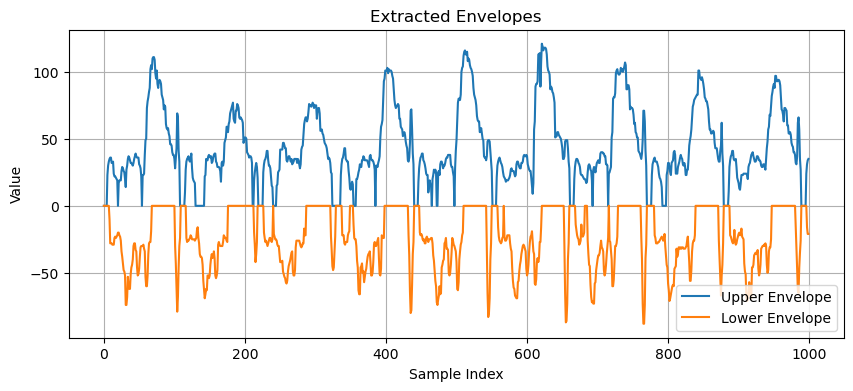

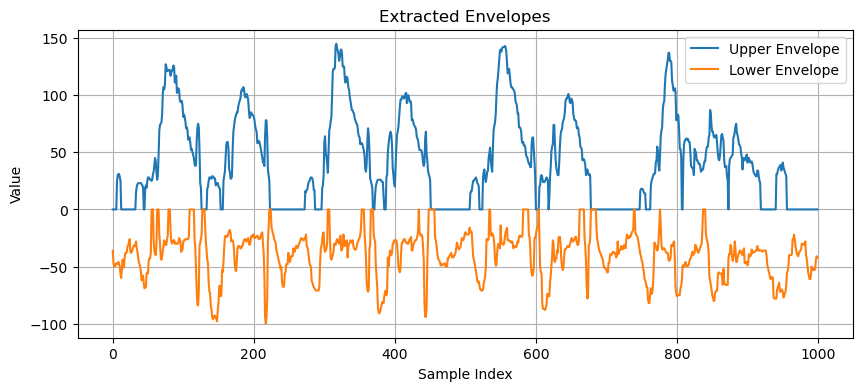

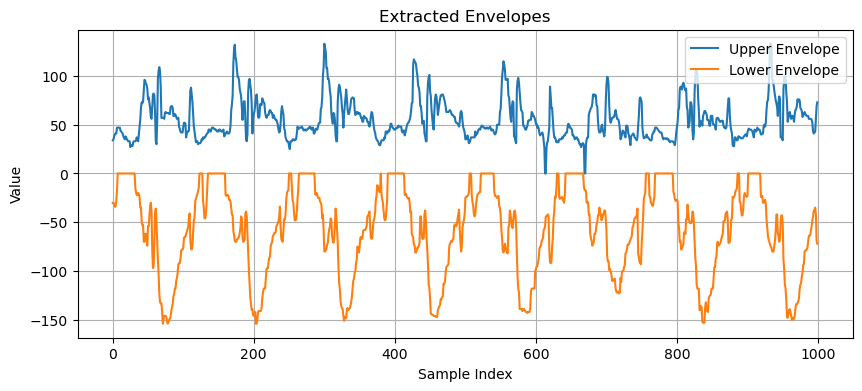

In [17]:
# Plotting extracted PWD upper and lower envelopes
for i in range(1, 11):
    mat = sio.loadmat(f'/home/tsu25/envelops/{i}_envelope.mat')
    x_up = mat['x_up'].squeeze()[:1000]
    x_down = mat['x_down'].squeeze()[:1000]
    plt.figure(figsize=(10,4))
    plt.plot(x_up, label='Upper Envelope')
    plt.plot(x_down, label='Lower Envelope')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Extracted Envelopes')
    plt.grid(True)
    plt.show()